# LibSBML Rules Definitions
[Reference Documentation](http://sbml.org/Special/specifications/sbml-level-2/version-1/html/sbml-level-2.html#SECTION00048000000000000000)
## The Important Bits:
Rules are essentially different formulae that are used to express different characteristics within the model. One of the challenges of incorporating these rules is determining what we will coerce and what we will not coerce. 

These rules are also determine the units that these models work in. I have yet to see any that are in any flavor of imperial measurement, but I think we'd all be cool with just doing a conversion to metric as standard if it does crop up. (Ease of Use/Am for science.)

Three Types of Rules:
- Algebraic Rules:
    - "The rule type AlgebraicRule is used to express equations that are neither assignments of model variables nor rates of change." (And the award for vaguest
       documentation goes to....)
    - The example is somewhat confusing, it's using the algebraic rule to create a constraint on the system.
        - Constraint: (S1+S2-T=0)
        -  "Weird format due to Jupyter actually recognizing the interior of the markdown<algebraicRule>
             <math xmlns="http://www.w3.org/1998/Math/MathML">
                    <apply>
                        <minus/>
                        <apply>
                            <plus/>
                            <ci> S2 </ci>
                            <ci> S1 </ci>
                        </apply>
                        <ci> T </ci>
                    </apply>
                </math>
            </algebraicRule>
- Assignment Rules:
    -  An Assignment Rule is essentially a function (In the math way, not the computational way) that acts as a setter for a population/concentration, 
       rate, or compartment/cell.
    -  One to One Relationship. (There can be a (singular) rule associative with a (singular) component of the model. Any more than that and the model throws an error.)
- Rate Rules:
    - Assigns a rate to a population, but as a mathematical formulae instead of a discrete (raw numeric) population. 
    - One to One as above.

## My big concern: Constraints and Solver Implementation
[Reference Documentation](http://sbml.org/Special/specifications/sbml-level-2/version-1/html/sbml-level-2.html#sec:algeraiceg)

I need to play around, but glancing at the solvers and the above constraint relationship I'm at a bit of a loss on how we would do this without having an interim step that stops and checks to see the constraint is valid. I would assume that in a standard model that because of how the stochastic model and populations would work together you wouldn't necessarily violate the above law (Can't make something from nothing.) but I am often wrong!

Need to check with research group on what they think.

# Let's Analyze the Rules Within the Models We Pulled Down

In [1]:
from libsbml import *
document = readSBML("BIOMD0000000017_url.xml")
model = document.getModel()
#And they couldn't make this an iterable for what reason?
for i in range(model.getNumSpecies()):
    species = model.getSpecies(i)
    print(species)

<Species ADP>
<Species NAD>
<Species ATP>
<Species NADH>
<Species pyruvate>
<Species lactate>
<Species CoA>
<Species halfglucose>
<Species AcCoA>
<Species AcP>
<Species Ac>
<Species AcO>
<Species EtOH>
<Species AcLac>
<Species AcetoinIn>
<Species AcetoinOut>
<Species Butanediol>
<Species O2>
<Species PO4>


Going for the rules, above model doesn't have rules.

In [2]:
from libsbml import *
import glob
import matplotlib
#They were everywhere and the indivduals I'm pulling don't have them. I'm just going to brute force it.
#Let's do some quick stats.

#Assignment = 0, Algebraic = 1, Rate = 2, None =3

Population = {"Assignment": 0, "Algebraic": 0, "Rate": 0, "None" :0}
RawRules = {"Compartment": 0, "Parameter": 0, "Assignment": 0, "Rate" :0, "Algebraic":0}

TotalRules = 0
TotalSpecies = 0

for x in glob.iglob("/home/jackson/Classifier/*.xml"):
    document = readSBML(x)
    model = document.getModel()
    for i in range(model.getNumSpecies()):
        TotalSpecies+=1
        speciesRule = model.getRule((model.getSpecies(i)).getId())
        if speciesRule is None:
            Population["None"]+=1
            continue
        if speciesRule.isAssignment():
            Population["Assignment"]+=1
            continue
        if speciesRule.isAlgebraic():
            Population["Algebraic"]+=1
            continue
        if speciesRule.isRate():
            Population["Rate"]+=1
            continue
            
    for i in range(model.getNumRules()):
        TotalRules +=1
        rule = model.getRule(i)
        if rule.isCompartmentVolume():
            RawRules["Compartment"]+=1
            continue
        if rule.isParameter():
            RawRules["Parameter"]+=1
            continue
        if rule.isAssignment():
            RawRules["Assignment"]+=1
            continue
        if rule.isRate():
            RawRules["Rate"]+=1
            continue
        if rule.isAlgebraic():
            RawRules["Algebraic"]+=1
            continue

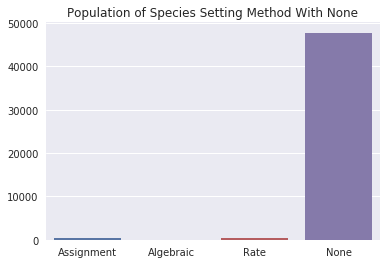

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
PopNames = list(Population.keys())
PopValues = list(Population.values())
ax = sns.barplot(x=PopNames, y=PopValues)
plt.title("Population of Species Setting Method With None")
plt.show()

### By None we mean that a rule was not used to set this value, not that it has "None" value

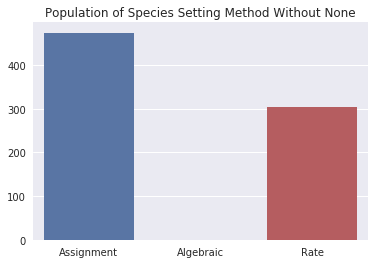

In [13]:
PopNamesN = list(Population.keys())[:-1]
PopValuesN = list(Population.values())[:-1]
ax = sns.barplot(x=PopNamesN, y=PopValuesN)
plt.title("Population of Species Setting Method Without None")
plt.show()

### According to the specification document, you can't use an Algebraic Rule to set a population but there sure is a way to check if someone is doing it. Bizarre.

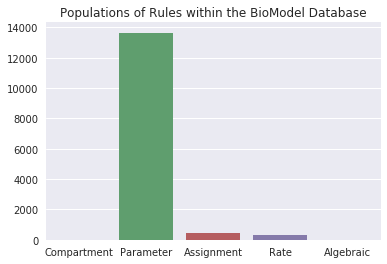

In [17]:
RawNames = list(RawRules.keys())
RawValues = list(RawRules.values())
ax = sns.barplot(x=RawNames, y=RawValues)
plt.title("Populations of Rules within the BioModel Database")
plt.show()

### At this point I think it's safe to say two things that there are certain rules that we might not want to coerce because they are vanishingly rare (or non-existant) within the database (Compartment, Algebraic)

### Below is a coercion of an SBML model into a Gillespy2 Model.

In [37]:
Split = {"HasPopRules": 0, "NoPopRules": 0, "HasGeneralRules":0, "NoGeneralRules": 0}
RulesFreeModels = []

for x in glob.iglob("/home/jackson/Classifier/*.xml"):
    document = readSBML(x)
    model = document.getModel()
    RuleFreeCheck = 0
    for i in range(model.getNumSpecies()):
        speciesRule = model.getRule((model.getSpecies(i)).getId())
        if i == (model.getNumSpecies()-1):
            RuleFreeCheck+=1
            Split["NoPopRules"]+=1
        if speciesRule is None:
            continue
        if speciesRule.isAssignment() or speciesRule.isAlgebraic() or speciesRule.isRate():
            Split["HasPopRules"]+=1
            break
    if model.getNumRules() == 0:
        RuleFreeCheck+=1
        Split["NoGeneralRules"]+=1
    else:
        Split["HasGeneralRules"]+=1
    if RuleFreeCheck == 2:
        RulesFreeModels.append(f'{x}')

In [38]:
print(Split)
print(len(RulesFreeModels))

{'HasPopRules': 122, 'NoPopRules': 287, 'HasGeneralRules': 387, 'NoGeneralRules': 211}
209


In [42]:
from random import choice
print(choice(RulesFreeModels))
print(f'The gods have spoken.')

/home/jackson/Classifier/MODEL1506070001_url.xml
The gods have spoken.


In [45]:
document = readSBML("/home/jackson/Classifier/MODEL1506070001_url.xml")
model = document.getModel()
print(writeSBMLToString(document))

<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level2/version4" metaid="_2cd9b14a-1f44-4d47-8040-b2bab4cf53c7" level="2" version="4">
  <model metaid="_860107aa-1a20-4e1a-a433-d876854d77e1" id="MODEL1506070001" name="Romano-Nguyen2014 -  MST2 and Raf1 Crosstalk">
    <notes>
      <body xmlns="http://www.w3.org/1999/xhtml">
        <p> Originally created by libAntimony v1.3 (using libSBML 4.1.0-b2) </p>
      </body>
    </notes>
    <annotation>
      <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:bqmodel="http://biomodels.net/model-qualifiers/">
        <rdf:Description rdf:about="#_860107aa-1a20-4e1a-a433-d876854d77e1">
          <bqmodel:is>
            <rdf:Bag>
              <rdf:li rdf:resource="http://identifiers.org/biomodels.db/MODEL1506070001"/>
            </rdf:Bag>
          </bqmodel:is>
        </rdf:Description>
      </rdf:RDF>
    </annotation>
    <listOfCompartments>
      <compartment metaid="d0df030d-3f32-4b76

### I'll spare you the details. It's a pretty large model but it has no rules.

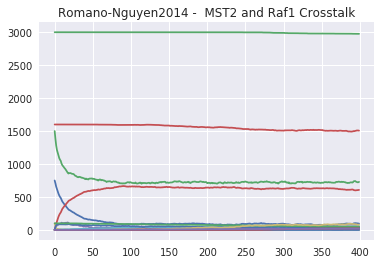

In [49]:
sys.path.append("/home/jackson/Research/GillesPy2/")
import gillespy2
model2 = gillespy2.import_SBML("/home/jackson/Classifier/MODEL1506070001_url.xml")
from gillespy2.basic_ssa_solver import BasicSSASolver
results = model2[0].run(solver=BasicSSASolver)
#That one line plot functionality tho.
model2[0].plot(results)

### Model import functionality for no rules works.